In [3]:
import os
import numpy as np
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch 
import time
from audioldm import build_model
from audioldm.latent_diffusion.ddim import DDIMSampler
from audioldm.pipeline import duration_to_latent_t_size
from utils.utils import *

sr = 16000

#test
#Saturn is working
#Saturn is working
#Saturn is working

In [4]:

model = build_model(model_name="audioldm-m-full")

torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

modelmem = torch.cuda.memory_allocated() / (1024 * 1024) 

print(f"{modelmem} MiB")
print(torch.cuda.memory_summary())

Load AudioLDM: %s audioldm-m-full
DiffusionWrapper has 415.95 M params.
DiffusionWrapper has 415.95 M params.


/home/manish/Ayush/audioldm/ldmenv/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


7038.32470703125 MiB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   7038 MiB |   7038 MiB |  11473 MiB |   4434 MiB |
|       from large pool |   6834 MiB |   6834 MiB |  11142 MiB |   4307 MiB |
|       from small pool |    203 MiB |    203 MiB |    330 MiB |    127 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   7038 MiB |   7038 MiB |  11473 MiB |   4434 MiB |
|       from large pool |   6834 MiB |   68

In [ ]:
prompt = "Electronic Dance Music followed by jazz piano followed by violin"
duration = 30.0  

In [6]:
model.cond_stage_model.embed_mode = "text"
text_list = [prompt] 

text_emb = model.get_learned_conditioning(text_list)

unconditional_text = [""] 
unconditional_embedding = model.get_learned_conditioning(unconditional_text)

In [7]:
sampler = DDIMSampler(model)

torch.cuda.synchronize()
latent_size = duration_to_latent_t_size(duration)
shape = [model.channels, latent_size, model.latent_f_size]
z = torch.randn([1] + shape).to(model.device)

ddim_steps = 200
ddim_eta = 0.1
unconditional_guidance_scale = 3.0

memory_before_diffusion = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

# Run diffusion
start_time = time.time()
with torch.no_grad(): 
    samples, _ = sampler.sample(
        S=ddim_steps,  
        batch_size=1,
        shape=shape,
        conditioning=text_emb,
        unconditional_conditioning=unconditional_embedding,
        unconditional_guidance_scale=unconditional_guidance_scale,
        eta=ddim_eta,
        verbose=False,
        x_T=z
    )
torch.cuda.synchronize()

# Get time and memory
diffusion_time = time.time() - start_time
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_diffusion

print(f"DIFFUSION ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"DIFFUSION CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"DIFFUSION TIME: {diffusion_time:.1f}s ({diffusion_time/ddim_steps:.3f}s per step)")

DDIM Sampler:   0%|          | 0/200 [00:00<?, ?it/s]

DDIM Sampler: 100%|██████████| 200/200 [01:00<00:00,  3.30it/s]

DIFFUSION ISOLATED PEAK: 8930.9 MiB (cost: +1884.1 MiB)
DIFFUSION CURRENT MEMORY: 7049.1 MiB
DIFFUSION TIME: 60.6s (0.303s per step)


VAE DECODER ISOLATED PEAK: 8321.9 MiB (cost: +1272.8 MiB)
VAE DECODER CURRENT MEMORY: 7049.9 MiB
VAE TIME: 0.1s


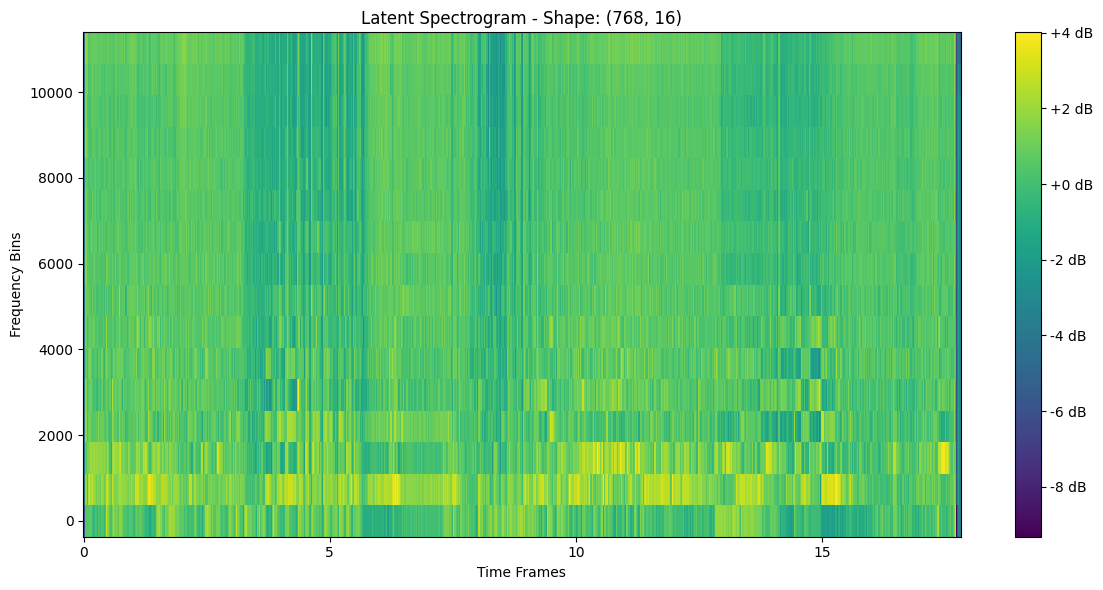

Latent stats - Min: -9.323, Max: 4.010, Mean: 0.326, Std: 0.942


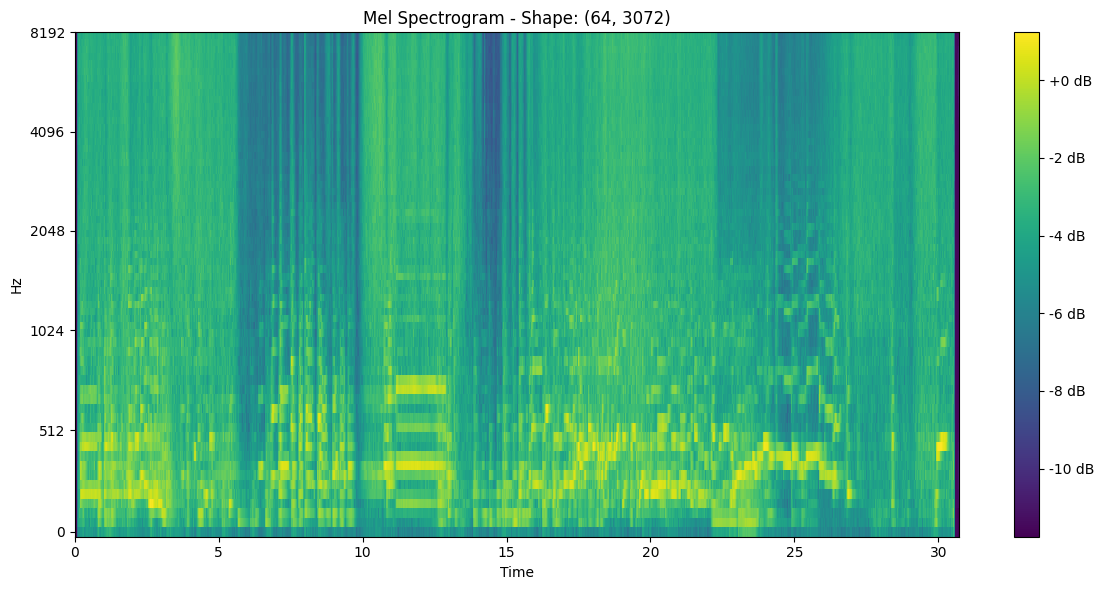

Mel stats - Min: -11.754, Max: 1.236, Mean: -3.861, Std: 1.518


In [8]:
# VAE DECODER VRAM MEASUREMENT
# Get memory before VAE and reset peak tracker
memory_before_vae = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

# Run VAE
start_time = time.time()
with torch.no_grad(): 
    mel_spectrogram = model.decode_first_stage(samples)
torch.cuda.synchronize()
vae_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vae

print(f"VAE DECODER ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"VAE DECODER CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"VAE TIME: {vae_time:.1f}s")
# print(torch.cuda.memory_summary())

plot_latent_spectrogram(samples, title="Latent Spectrogram")
plot_mel_spectrogram(mel_spectrogram, title="Mel Spectrogram", sr=sr)

In [9]:
memory_before_vocoder = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

start_time = time.time()
with torch.no_grad(): 
    waveform = model.mel_spectrogram_to_waveform(mel_spectrogram)[0]
torch.cuda.synchronize()
vocoder_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vocoder

print(f"VOCODER ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"VOCODER CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"VOCODER TIME: {vocoder_time:.1f}s")

ipd.display(ipd.Audio(waveform, rate=sr))

VOCODER ISOLATED PEAK: 7412.6 MiB (cost: +362.8 MiB)
VOCODER CURRENT MEMORY: 7049.9 MiB
VOCODER TIME: 0.2s


In [10]:
import soundfile as sf

# Ensure waveform is a NumPy array and has the correct shape
waveform = waveform.squeeze()  # Remove batch dimension if present
if isinstance(waveform, torch.Tensor):
    waveform = waveform.cpu().numpy()  # Convert to NumPy array if it's a PyTorch tensor

# Save the generated audio to a file
output_path = "../output/generation"
os.makedirs(output_path, exist_ok=True)
filename = f"complex_regular.wav"  # Simplify filename
sf.write(os.path.join(output_path, filename), waveform, sr)

print(f"Audio saved to {os.path.join(output_path, filename)}")

Audio saved to ../output/generation/complex_regular.wav
